Hi, our names are *Illyuvieva Alice* and *Tafintseva Albina* and we decided to write a tutirial on a subject of ***ARIMA model***. 

In this tutorial we want to illustrate how ARIMA model can be applied in python, how we can measure it's efficiency and make predictions. 

We have chosen data of COVID19, this data contains infromation about countries from 2020-01-22 : 2021-02-01. Data is collected in the way that all indicators are summed with the previous ones, so each day does not indicate the statistics of that day, put indicates the overall statictics for all pevious days since 2020-01-22. For each day for each country we can see the sum of number of people who had confirmed COVID19 (to that day), number of people who recovered (since 2020-01-22 to that day) and number of people who had died since 2020-01-22 to that day.

In the next sell below you can see all the libraries which are going to be used in order to upload data, to modify data, to construct arima model, to extract train and test parts from the data, to get predictions, to estimate the model, to visualize and so on.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas import DataFrame

...Uploading data

In [2]:
csv_url = 'time-series-19-covid-combined.csv'
data = pd.read_csv(csv_url, index_col=0, parse_dates=True, squeeze=True)

data

,Country/Region,Province/State,Confirmed,Recovered,Deaths
Date,,,,,
2020-01-22,Afghanistan,NaN,0,0.0,0
2020-01-23,Afghanistan,NaN,0,0.0,0
2020-01-24,Afghanistan,NaN,0,0.0,0
2020-01-25,Afghanistan,NaN,0,0.0,0
2020-01-26,Afghanistan,NaN,0,0.0,0
...,...,...,...,...,...
2021-01-28,Zimbabwe,NaN,32646,24419.0,1160
2021-01-29,Zimbabwe,NaN,32952,24872.0,1178
2021-01-30,Zimbabwe,NaN,33273,25361.0,1193


Now you can see visualized data. Therefore, it is time to tell you what task we want to solve and how we will need to modify data in order to complete it.

So, we decided that we want to explore statistics about deaths in Afganistan. And make predictions about number of deaths in the future. We say, that: 

H0 (null hypothesis) = number of deaths in Afganistan is going to decrease. 

1. We will take only data concerning Afganistan (trim number of rows in th dataset)
2. We will drop all columns in the resulted from '2.' dataset, apart from dates and number of deaths
3. We are going to create column 'deaths per day' in which deaths per day will be calculated smart, right?) ) - the algorithm is pretty easy and understandable from the code
 

 That's all for modifications with dataset, and below you can see the code for everything described above. 
 
 Enjoy!

In [3]:
data = data.drop(['Country/Region', 'Province/State', 'Confirmed', 'Recovered'], axis = 1)
data = data.iloc[0:377]
data

,Deaths
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2021-01-28,2397
2021-01-29,2399
2021-01-30,2400


In [4]:
new_data_deaths = list()
old_data_deaths = list(data['Deaths'])

new_data_deaths.append(old_data_deaths[0])
for i in range(1, len(old_data_deaths)):
    num_of_deaths = old_data_deaths[i] - old_data_deaths[i - 1]
    new_data_deaths.append(num_of_deaths)

data['Deaths_per_day'] = new_data_deaths
data

,Deaths,Deaths_per_day
Date,,
2020-01-22,0,0
2020-01-23,0,0
2020-01-24,0,0
2020-01-25,0,0
2020-01-26,0,0
...,...,...
2021-01-28,2397,8
2021-01-29,2399,2
2021-01-30,2400,1


In [5]:
data = data.drop(['Deaths'], axis = 1)
data

,Deaths_per_day
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2021-01-28,8
2021-01-29,2
2021-01-30,1


<AxesSubplot:xlabel='Date'>

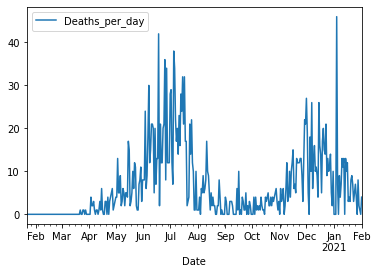

In [6]:
data.plot()

**Examine whether data is stationary or not:**

1. H0: time-series data is non-stationary
2. apply adfuller() function to our time-series
3. make conclusion (if p-value of the test is < 0.05 => reject H0)

In [7]:
from statsmodels.tsa.stattools import adfuller

result_of_adfuller = adfuller(data['Deaths_per_day'])
print('p-value: %f' % result_of_adfuller[1])

p-value: 0.286124


P-value is greater than the sighnificance level => process is non-stationary => we have to difference the series and whatch with what level of differnec we will be able to achive stationarity. 
Also it is vital to do, because when we will specificate our model, we will have to spacificate order = (p, d, q), where d stands for the level of difference.


Firstly look at the original data:

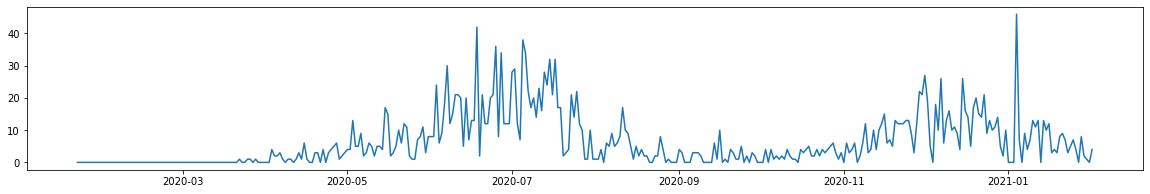

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
plt.rcParams["figure.figsize"] = (20,3)
print(plt.plot(data['Deaths_per_day']))


Now our data with the first order of differencing:

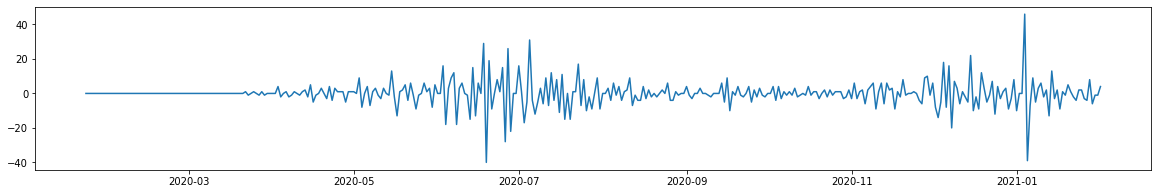

In [9]:
plt.rcParams["figure.figsize"] = (20,3)
difference_order_1 = data['Deaths_per_day'].diff()
print(plt.plot(difference_order_1))


Now our data with the second order of differencing:

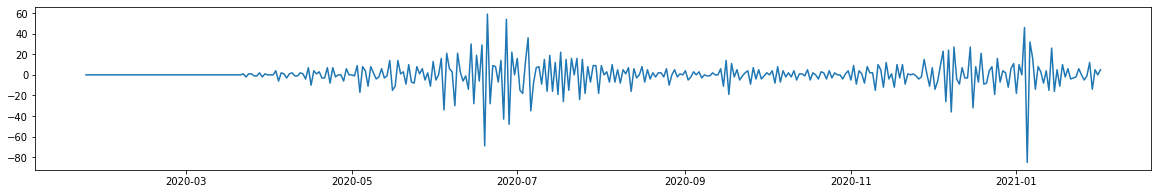

In [10]:
plt.rcParams["figure.figsize"] = (20,3)
difference_order_2 = data['Deaths_per_day'].diff().diff()
print(plt.plot(difference_order_2))


=> We decided to take difference level = 1, as level differnce > 1 does not make much changes

Now we specificate our model. We do not need date columns, as we are constructing ARIMA models regarding time-series data of deaths.


In [11]:
# import pmdarima as pm
model = ARIMA(data, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())
# model_fit = pm.auto_arima(data, start_p = 1, start_q = 1, max_p = 4, max_q = 4, d = 1)
# print(model.summary())

/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
                               SARIMAX Results                                
Dep. Variable:         Deaths_per_day   No. Observations:                  377
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1192.717
Date:                Wed, 03 Feb 2021   AIC                           2397.434
Time:                        18:33:23   BIC                           2421.011
Sample:                   

Interpretation of our ARIMA model:

( $Y_t = Y_{t-1} + e_t - 0.8205*e_{t-1}$ )  -  for auto arima model

<AxesSubplot:xlabel='Date'>

<function matplotlib.pyplot.show(close=None, block=None)>

<AxesSubplot:ylabel='Density'>

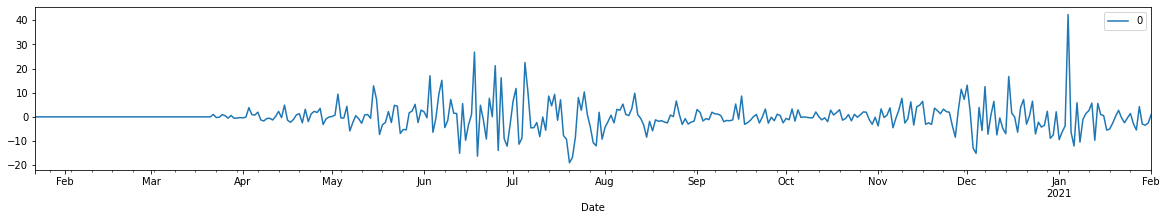

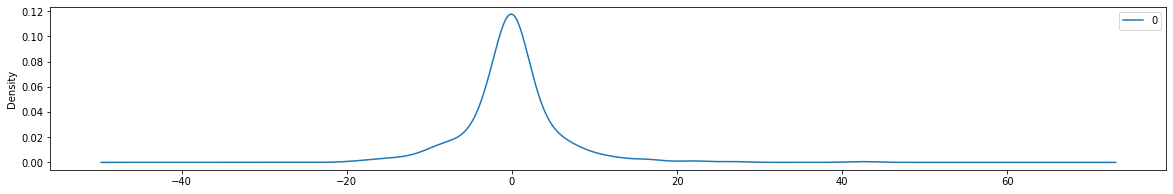

                0
count  377.000000
mean     0.020154
std      5.765514
min    -19.031711
25%     -2.210835
50%      0.000000
75%      1.782154
max     42.401188


In [12]:
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show

residuals.plot(kind='kde')
pyplot.show()

print(residuals.describe())

Figure(504x504)


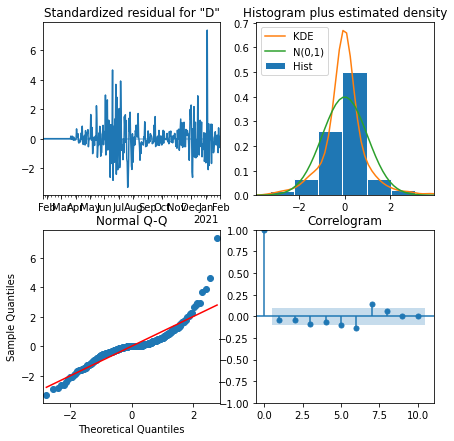

In [14]:
print(model_fit.plot_diagnostics(figsize=(7,7)))

Interpretation of residual plots:

1.
2.
3. Normal Q-Q : All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed. => We can conclude that in our data disrtibution may be a little skewed.
4. 



**Accuracy metrics**

So here are some of the commonly used accuracy metrics for time-series data:

1. Mean Absolute Percentage Error (MAPE)
2. Mean Error (ME)
3. Mean Absolute Error (MAE)
4. Mean Percentage Error (MPE)
5. Root Mean Squared Error (RMSE)
6. Correlation between the Actual and the Forecast (corr)
7. Min-Max Error (minmax)

Below we will get those metrics for our models

In [15]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})


**Rolling Forecast ARIMA**

predicted = 2.118529, expected = 2.000000
predicted = 1.345952, expected = 0.000000
predicted = 2.092220, expected = 3.000000
predicted = 1.204468, expected = 2.000000
predicted = 2.515162, expected = 0.000000
predicted = 0.602313, expected = 0.000000
predicted = 1.132057, expected = 0.000000
predicted = 0.682552, expected = 4.000000
predicted = 1.614980, expected = 0.000000
predicted = 1.225667, expected = 4.000000
predicted = 1.230941, expected = 1.000000
predicted = 2.448075, expected = 2.000000
predicted = 1.032420, expected = 1.000000
predicted = 2.435553, expected = 2.000000
predicted = 1.297967, expected = 1.000000
predicted = 1.893140, expected = 4.000000
predicted = 1.934065, expected = 2.000000
predicted = 2.449427, expected = 1.000000
predicted = 1.320583, expected = 1.000000
predicted = 1.998825, expected = 0.000000
predicted = 1.101722, expected = 4.000000
predicted = 2.029781, expected = 3.000000
predicted = 2.442545, expected = 4.000000
predicted = 2.128449, expected = 5

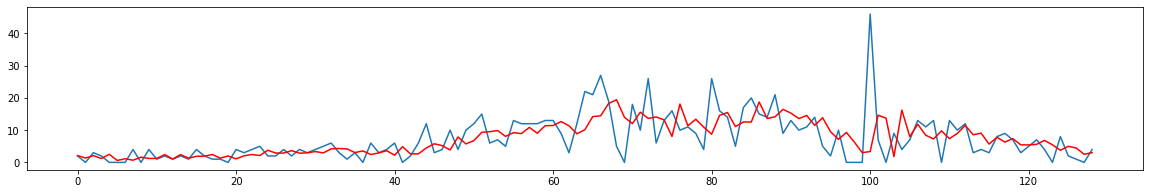

In [16]:
X = data.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted = %f, expected = %f' % (yhat, obs))

pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

**Forecast Accuracy**

In [17]:
test1 = list()
for i in range(len(test)):
    test1.append(int(test[i]))

print(forecast_accuracy(np.array(predictions), np.array(test1)))

{'mape': inf, 'me': 0.028708417980527486, 'mae': 4.055030079581947, 'mpe': inf, 'rmse': 6.352599344889846, 'corr': 0.4893944167186636, 'minmax': 0.43996119566745795}
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
